# ENSO analysis using 20CRv3 and CMIP6 data
This notebook calculates and plots the NINO3.4 index using monthly sea surface temperature anomalies using CMIP6 historical model output (43 models) and 20CRv3 reanalysis data (79 members).  

Notebook last updated on 9 May 2023 by Kate Bongiovanni.

In [9]:
path = '/g/data/w40/W48_GDATA_MOVED/kb6999'

In [10]:
# add path to save figures
fig_path = '/g/data/w40/W48_GDATA_MOVED/kb6999/Masters_paper/FIGURES'

In [11]:
import xarray as xr, matplotlib.pyplot as plt
import sys 
sys.path.append(f'{path}/Masters_paper') 
# import custom functions
import GRL_functions as func

from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap 
import dask.diagnostics # to check how long something is taking to load

In [12]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
ts_dir = '/historical/r1i1p1f1/Amon/ts/gr1.5/'
print(institution_dir, tas_dir, pr_dir, ts_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/ /historical/r1i1p1f1/Amon/ts/gr1.5/


## Read in model data

In [13]:
models_ts = func.read_models(institution_dir, ts_dir, '1850-01','2015-01')

54 model paths found and loaded into the dictionary "models"
54 models have been successfully loaded into an xarray


In [14]:
models = models_ts.sel(model= ['ACCESS-CM2','ACCESS-ESM1-5','AWI-CM-1-1-MR','AWI-ESM-1-1-LR','BCC-CSM2-MR','BCC-ESM1',
                             'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 
                             'CMCC-CM2-HR4', 'CMCC-CM2-SR5' ,'CanESM5', 'E3SM-1-1' ,'E3SM-1-1-ECA' ,'EC-Earth3', 
                             'EC-Earth3-AerChem' , 'EC-Earth3-Veg-LR', 'FGOALS-f3-L' ,'FGOALS-g3', 'FIO-ESM-2-0', 
                             'GFDL-CM4' ,'GFDL-ESM4', 'GISS-E2-1-G' ,'GISS-E2-1-G-CC', 'GISS-E2-1-H' ,'IITM-ESM', 
                             'INM-CM4-8', 'INM-CM5-0' ,'IPSL-CM6A-LR', 'KACE-1-0-G', 'MIROC6' ,'MPI-ESM-1-2-HAM',
                             'MPI-ESM1-2-LR' ,'MRI-ESM2-0', 'NESM3', 'NorCPM1' ,'NorESM2-LM', 'NorESM2-MM',
                             'SAM0-UNICON', 'TaiESM1'])
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


In [15]:
# area weighting 
models_w = models*np.cos(models_ts.lat*(np.pi/180))

In [16]:
# calculate the multi-model mean
mmm = models_w.mean(dim='model')

## Read in 20CR data

In [17]:
# define path where netcdfs of temperature are stored
R_path = '/g/data/w40/W48_GDATA_MOVED/kb6999/Reanalysis/'

In [18]:
# open the 20CRv3 multi member mean of temperature (multi-member mean calculated using an 1850-1880 climatology)
R_em_mon_Glob_r = xr.open_dataset(f'{R_path}20CR_TMP_data_for_plots/mmm_anom_glob.nc')

In [19]:
# reverse the latitude axis so it goes from -90 to 90
R_em_mon_Glob = R_em_mon_Glob_r.reindex(lat=list(reversed(R_em_mon_Glob_r.lat)))

## Calculate NINO3.4 index

In [23]:
# calculate the nino3.4 index for 20CR ensemble mean for every month divided by std
R_nino34 = func.nino34(R_em_mon_Glob.tmp, '1850-01', '1879-12', 1)

In [24]:
# calculate the nino3.4 index for multi-model mean for every month divided by std
Mmm_nino34 = func.nino34(mmm, '1850-01', '1879-12', 1)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


In [25]:
# calculate the nino3.4 index for all models for every month divided by std
M_nino34 = func.nino34(models_w, '1850-01', '1879-12', 1)
M_nino34

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:  (time: 1980, model: 43)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2014-12-31
  * model    (model) <U17 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'TaiESM1'
    month    (time) int64 dask.array<chunksize=(5,), meta=np.ndarray>
Data variables:
    ts       (model, time) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>

### Threshold

In [26]:
# set the threshold for el nino/la nina events
THOLD = 0.4

# Graphs

In [27]:
# set the default font size
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [28]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [29]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

[########################################] | 100% Completed | 529.17 ms
[########################################] | 100% Completed | 532.43 ms
[########################################] | 100% Completed | 428.16 ms
[########################################] | 100% Completed | 526.34 ms
[########################################] | 100% Completed | 530.58 ms
[########################################] | 100% Completed | 32.31 s
[########################################] | 100% Completed | 22.20 s
[########################################] | 100% Completed | 22.10 s
[########################################] | 100% Completed | 21.78 s
[########################################] | 100% Completed | 24.44 s
[########################################] | 100% Completed | 6.39 sms
[########################################] | 100% Completed | 9.00 ss
[########################################] | 100% Completed | 9.73 ss
[########################################] | 100% Completed | 9.39 ss
[########

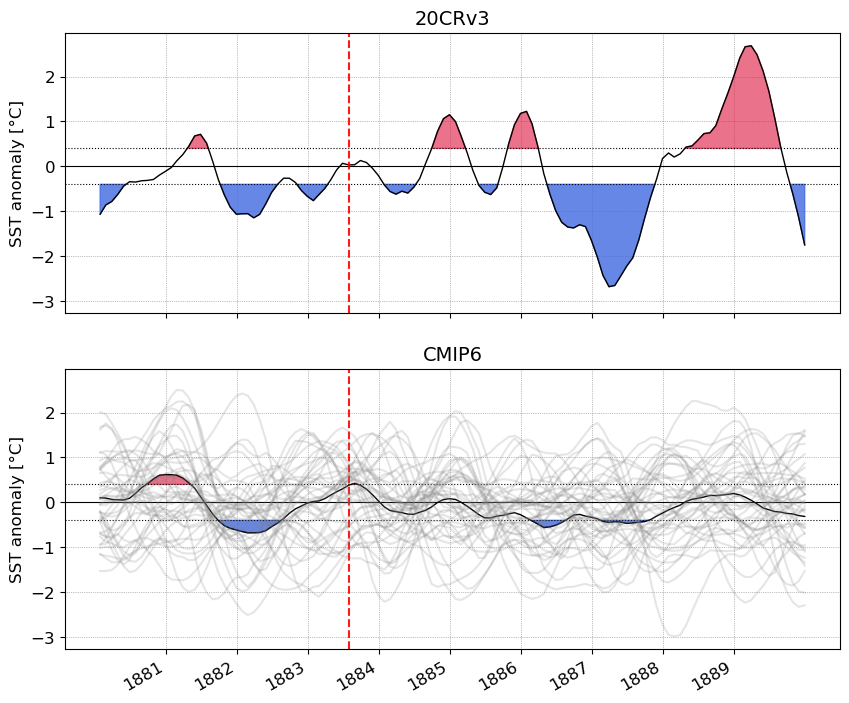

In [30]:
# plot time series of nino3.4 index for CMIP6 and 20CR data
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,8))

with dask.diagnostics.ProgressBar():
    func.nino34_plot(R_nino34.sel(time=slice('1880-01','1889-12')), e_date, THOLD, ax = axes[0])
    func.nino34_plot(Mmm_nino34.ts.sel(time=slice('1880-01','1889-12')), e_date, THOLD, ax = axes[1])
    for m, model in enumerate(M_nino34.model):
        M_nino34.ts.sel(model=model).sel(time=slice('1880-01','1889-12')).plot(ax = axes[1], color='gray', 
                alpha = 0.2)

# set the axis labels and title
axes[0].set(ylabel= f'SST anomaly [{deg}C]', title = '20CRv3') 
axes[1].set(ylabel= f'SST anomaly [{deg}C]', title = 'CMIP6', xlabel=None)

plt.savefig(f'{fig_path}/RM_nino34_index_all_mods_1880-1890.pdf', dpi=300, bbox_inches='tight')